# Inference of Anomaly Cross Correlation skill in multi-year hindcast evaluation

A demonstration using synthetic, independent (AR) "ensemble hindcast" and "observed" series.

**Please chime in at any point**

In [2]:
import dask

import numpy as np

import xarray as xr

import matplotlib

import matplotlib.pyplot as plt

from src import utils, plot, stats, ar_model

In [ ]:
matplotlib.rcParams["figure.figsize"] = (14, 6)
matplotlib.rcParams["font.size"] = 12

_ = dask.config.set(**{"array.slicing.split_large_chunks": False})

In [ ]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [ ]:
DATA_DIR = "../../data/processed"

## We construct some synthetic series by fitting an Autoregressive model to a climate index calculated from reanalysis data. 

E.g. let's focus on the Boreal Winter Atlantic multidecadal variability (AMV) index computed from HadISST

In [ ]:
HadISST = xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True)
AMV = utils.calculate_period_AMV_index(
    HadISST["sst"],
    [12, 1, 2, 3],
).compute()
AMV = utils.get_observation_rolling_mean(AMV, [1, 4, 8])

The synthetic observations are generated by randomly drawing $N_{time}$ samples of the AR model.

The synthetic ensemble hindcasts are generated by running the model forward in time from $N_{time}$ randomly drawn samples of the AR model. The initial condition for each $N_{member}$ ensemble member is the same, but their trajectories differ because the noise component is different for each member.

The synthetic observations and hindcasts are independent.

Below, I generate $N_{sample}=2000$ pairs of such signals

In [ ]:
N_time = 200
N_samples = 2000
N_members = 150
rolling_means = [4, 8]

In [ ]:
%%time

input_data = AMV.sel(rolling_mean=1).astype("float32")

fcst = ar_model.generate_samples_like(
    input_data,
    order="select_order",
    n_times=N_time,
    n_samples=N_samples,
    n_members=N_members,
    rolling_means=rolling_means,
    plot_diagnostics=True,
)

obsv = ar_model.generate_samples_like(
    input_data,
    order="select_order",
    n_times=N_time,
    n_samples=N_samples,
    rolling_means=rolling_means,
    plot_diagnostics=False,
)

Let's focus for now on 8-year mean quantities, which is commonplace in the literature. 

Note, means are computed in a rolling fashion along **time** for the synthetic observations and along **lead** for the synthetic hindcasts.

## A common approach that has emerged for inferring the significance of skill metrics in the multi-year community is a block-bootstrapping approach using a fixed blocksize, $L$, of 5 points:

1. Randomly sample with replacement $N_{time}$ validation cases. To take autocorrelation into account, this is done in blocks of five consecutive cases.

2. For each case, randomly sample with replacement $N_{member}$ ensemble members.

3. Compute the required statistic for the ensemble mean (here we're interested in the ACC).

4. Repeat steps (1)–(3) $N_{iteration}$ (= 1000) times to create a probability distribution.

5. Obtain the significance level on the basis of a two-tailed test of the hypothesis that skill (ACC) is 0.

Let's do this for one of our pairs of synthetic observations/hindcasts with $N_{time}$ = 45 and $N_{member}$ = 40 (typical values)

In [12]:
N_time = 45
N_member = 40
sample = 10

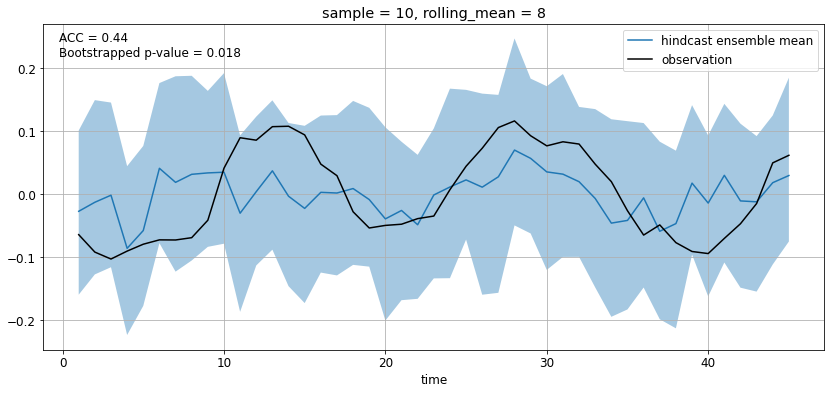

In [13]:
fcst_samp = fcst.sel(
    time=slice(N_time), member=slice(N_member - 1), rolling_mean=8, sample=sample
)
fcst_plot = fcst_samp - fcst_samp.mean(["time", "member"])
obsv_samp = obsv.sel(time=slice(N_time), rolling_mean=8, sample=sample)
obsv_plot = obsv_samp - obsv_samp.mean("time")

plt.fill_between(
    fcst_plot.time.values,
    fcst_plot.quantile(0.05, dim="member"),
    fcst_plot.quantile(0.95, dim="member"),
    color="C0",
    edgecolor="none",
    alpha=0.4,
)
(1 * fcst_plot.mean("member")).plot(color="C0", label="hindcast ensemble mean")
obsv_plot.plot(color="k", label="observation")

r, p = stats.infer_metric(
    fcst_samp,
    obsv_samp,
    metric="pearson_r",
    method="bootstrap",
    method_kwargs=dict(
        blocks={"time": 5, "member": 1}, n_iteration=1000, transform="Fisher_z"
    ),
)
plt.text(
    0.02,
    0.90,
    f"ACC = {r.values:.2f}\nBootstrapped p-value = {p.values:.3f}",
    transform=plt.gca().transAxes,
)

plt.grid()
_ = plt.legend(loc="upper right")

Most multi-year verification studies assign significance for p-values less than 0.05, so for this sample, we would say that our hindcasts are skillful. 

Of course, it's not surprising that I can find examples of high correlation in my $N_{sample}$s of synthetic signals. However, the p-value estimated by the "standard" block bootstrap approach is far too low. Actually, correlations this high occur far more often than this p-value suggests.

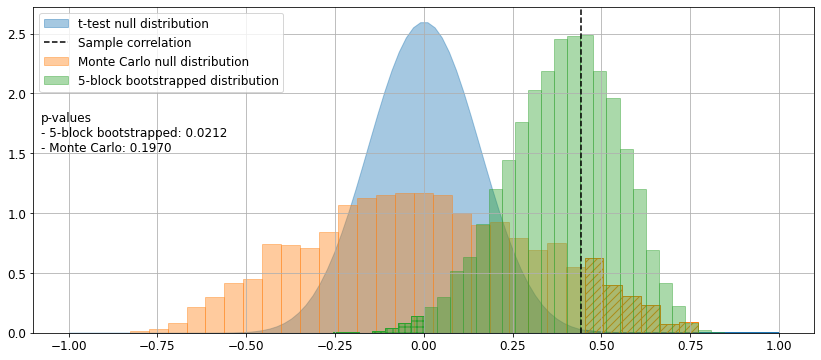

In [14]:
plot.pearson_r_distributions(
    fcst.sel(
        time=slice(N_time),
        member=slice(N_member - 1),
        rolling_mean=8,
    ),
    obsv.sel(time=slice(N_time), rolling_mean=8),
    sample,
    block=5,
)

This is because the serial correlation is high due to:

1. The nature of the process being assessed
2. The 8-year averaging (largest effect on the observations)
3. The ensemble averaging

So the effective sample size is very small.

## Let's see how the Type I error rates (i.e. the proportion of samples that reject the null hypothesis when it's actually true) at $\alpha = 0.05$ depend on $N_{time}$ and $N_{member}$.

In [15]:
%%time
clobber = False

if clobber:
    T1_er, r_crit = stats.get_Type_I_error_rates(
        fcst,
        obsv,
        n_times=range(15, 200, 15),
        n_members=[10, 40, 150],
        metric="pearson_r",
        method="bootstrap",
        method_kwargs=dict(
            blocks={"time": 5, "member": 1}, n_iteration=1000, transform="Fisher_z"
        ),
        alpha=0.05,
        sample_blocks=500,
    )
    
    T1_er.to_dataset(name="T1_er").to_netcdf(
        f"{DATA_DIR}/amv_T1error_block5.nc",
        mode="w"
    )
    r_crit.to_dataset(name="r_crit").to_netcdf(
        f"{DATA_DIR}/amv_rcrit_block5.nc",
        mode="w"
    )
else:
    T1_er = xr.open_dataset(
        f"{DATA_DIR}/amv_T1error_block5.nc"
    )["T1_er"]
    r_crit = xr.open_dataset(
        f"{DATA_DIR}/amv_rcrit_block5.nc"
    )["r_crit"]

CPU times: user 6.37 ms, sys: 485 µs, total: 6.85 ms
Wall time: 7.79 ms


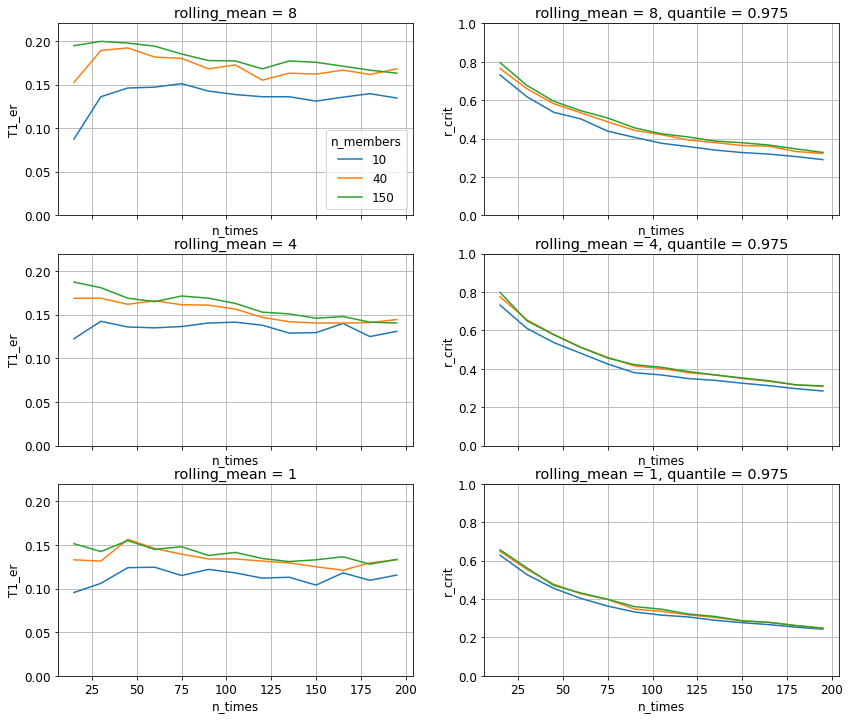

In [16]:
fig = plt.figure(figsize=(14, 4 * T1_er.sizes["rolling_mean"]))
axs = fig.subplots(T1_er.sizes["rolling_mean"], 2, sharex=True)

for idx, av in enumerate(T1_er["rolling_mean"][::-1]):
    T1_er.sel(rolling_mean=av).plot.line(
        ax=axs[idx, 0], x="n_times", add_legend=True if idx == 0 else False
    )
    r_crit.sel(rolling_mean=av).plot.line(ax=axs[idx, 1], x="n_times", add_legend=False)
    axs[idx, 0].set_ylim(0, 0.22)
    axs[idx, 0].grid()
    axs[idx, 1].set_ylim(0, 1)
    axs[idx, 1].grid()

## Things I'm exploring/battling with:

### 1. My synthetic model

I'm struggling a little to come up with a nice, convincing story that uses synthetic series. I'm confident that the situation is actually worse (higher error rates) than my model fits to a given index would suggest. For example, I'd really like to touch on the NAO, which has received a lot of attention around the signal-to-noise paradox. However, the whole argument around the signal-to-noise paradox is that the "predictable component" of the signal is very weak. Fitting to the annual NAO index from HadSLP2 returns an AR(0) model. Large synthetic ensemble means of this model don't represent real hindcast model ensemble means.

In [5]:
HadSLP = xr.open_zarr(f"{DATA_DIR}/psl_HadSLP2r.zarr", use_cftime=True)
NAO = utils.calculate_period_NAO_index(
    HadSLP["slp"],
    [12, 1, 2, 3],
).compute()
NAO = utils.get_observation_rolling_mean(NAO, [1, 4, 8])

In [6]:
models = [
    "CanESM5",
    "CESM1-1-CAM5-CMIP5",
    "EC-Earth3",
    "HadGEM3-GC31-MM",
    "IPSL-CM6A-LR",
    "MIROC6",
    "MPI-ESM1-2-HR",
    "NorCPM1",
]

N_inits_min = 57

NAO_mm = []
prev_mem = 0
for model in models:
    psl = xr.open_zarr(f"{DATA_DIR}/psl_Amon_{model}_dcpp.zarr", use_cftime=True) / 100

    model_NAO = utils.calculate_period_NAO_index(
        psl["psl"].isel(init=slice(N_inits_min)),
        [12, 1, 2, 3],
    )

    # Process so that different models can be aligned
    model_NAO = model_NAO.sel(lead=slice(14, 120))
    model_NAO = model_NAO.assign_coords({"lead": range(1, 10)})
    model_NAO = model_NAO.assign_coords({"member": model_NAO.member + prev_mem})
    model_NAO = model_NAO.assign_coords(
        {"init": range(1960, 1960 + model_NAO.sizes["init"])}
    )
    model_NAO = utils.round_to_start_of_month(model_NAO, "time")
    prev_mem = model_NAO.member.values[-1]
    NAO_mm.append(model_NAO.compute())

NAO_mm = xr.concat(NAO_mm, dim="member", coords="minimal", compat="override")
NAO_hindcast = utils.get_hindcast_mean(NAO_mm, mean_lead_range=[(0, 8)]).squeeze()

In [8]:
input_data = NAO.sel(rolling_mean=1).astype("float32")

NAO_synthetic = ar_model.generate_samples_like(
    input_data,
    order="select_order",
    n_times=NAO_hindcast.sizes["time"],
    n_samples=1,
    n_members=NAO_mm.sizes["member"],
    rolling_means=[8],
    plot_diagnostics=False,
).sel(rolling_mean=8)

For example, the following panels show the ensemble mean year 1-8 NAO predictions from 110-member CMIP6 DCPP ensemble and from 110-member synthetic forecasts

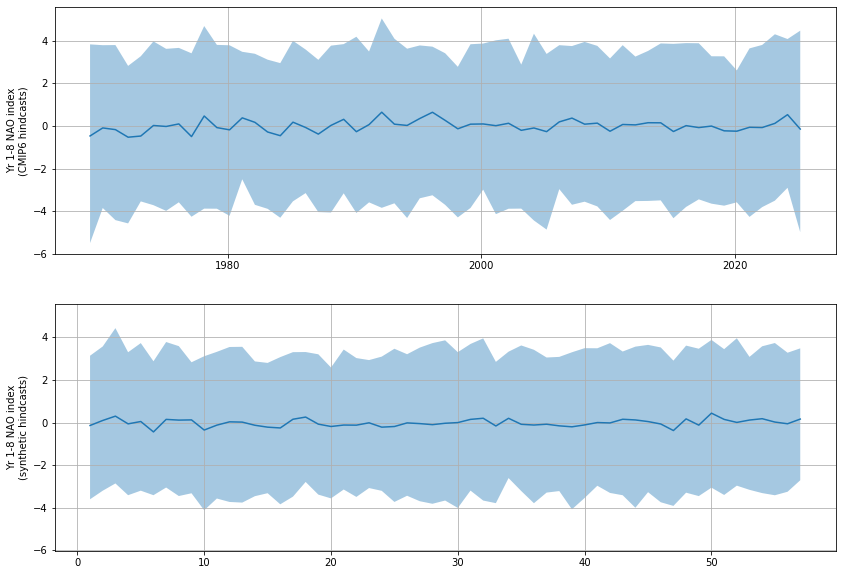

In [9]:
fig = plt.figure(figsize=(14, 10))
axs = fig.subplots(2, 1, sharey=True)

axs[0].fill_between(
    NAO_hindcast.time.values,
    NAO_hindcast.quantile(0.05, dim="member"),
    NAO_hindcast.quantile(0.95, dim="member"),
    alpha=0.4,
)
axs[0].plot(NAO_hindcast.time.values, NAO_hindcast.mean("member"))
axs[0].set_ylabel("Yr 1-8 NAO index\n(CMIP6 hindcasts)")
axs[0].grid()

axs[1].fill_between(
    NAO_synthetic.time.values,
    NAO_synthetic.quantile(0.05, dim="member"),
    NAO_synthetic.quantile(0.95, dim="member"),
    alpha=0.4,
)
axs[1].plot(NAO_synthetic.time.values, NAO_synthetic.mean("member"))
axs[1].set_ylabel("Yr 1-8 NAO index\n(synthetic hindcasts)")
axs[1].grid()

In [10]:
print(
    f"AR model fit to CMIP6 ensemble mean hindcast: order {ar_model.fit(NAO_hindcast.mean('member'), order='select_order').order.values}"
)
print(
    f"AR model fit to synthetic ensemble mean hindcast: order {ar_model.fit(NAO_synthetic.mean('member'), order='select_order').order.values}"
)

AR model fit to CMIP6 ensemble mean hindcast: order 10
AR model fit to synthetic ensemble mean hindcast: order 0


And so Type 1 error rates for NAO-like sythetic series are low, but I don't think this is representative of the actual situation

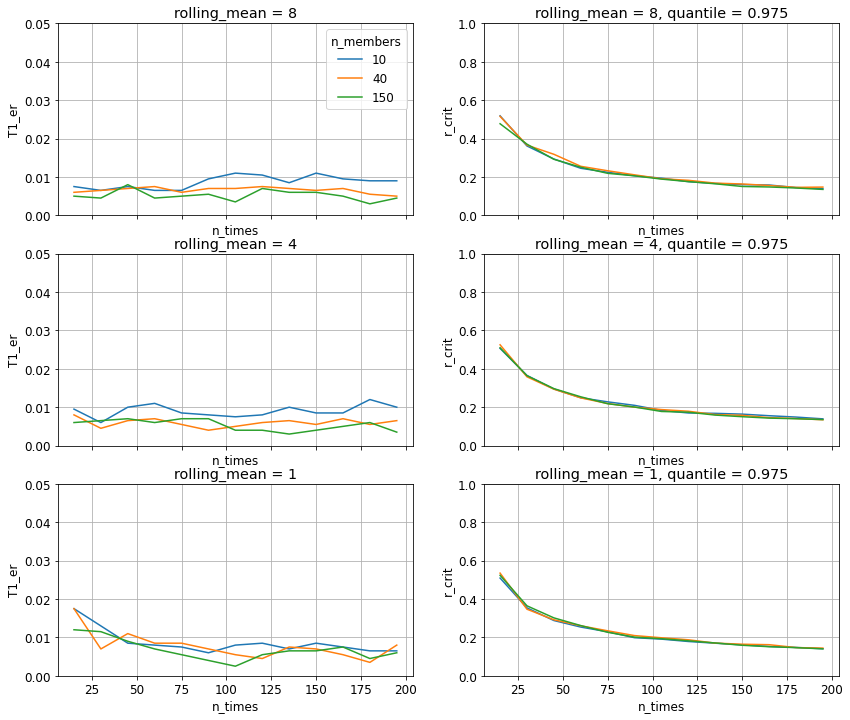

In [27]:
T1_er = xr.open_dataset(f"{DATA_DIR}/nao_T1error_block5.nc")["T1_er"]
r_crit = xr.open_dataset(f"{DATA_DIR}/nao_rcrit_block5.nc")["r_crit"]

fig = plt.figure(figsize=(14, 4 * T1_er.sizes["rolling_mean"]))
axs = fig.subplots(T1_er.sizes["rolling_mean"], 2, sharex=True)

for idx, av in enumerate(T1_er["rolling_mean"][::-1]):
    T1_er.sel(rolling_mean=av).plot.line(
        ax=axs[idx, 0], x="n_times", add_legend=True if idx == 0 else False
    )
    r_crit.sel(rolling_mean=av).plot.line(ax=axs[idx, 1], x="n_times", add_legend=False)
    axs[idx, 0].set_ylim(0, 0.05)
    axs[idx, 0].grid()
    axs[idx, 1].set_ylim(0, 1)
    axs[idx, 1].grid()

### 2. Other things:
- Can we usefully quantify the impact of trends which are often not removed?
- Can we provide an alternative way forward? How do different significance tests perform? E.g. [Ebisuzaki 1997](https://doi.org/10.1175/1520-0442(1997)010<2147:AMTETS>2.0.CO;2)
- Is there a blocksize that is appropriate? Is it preventitively large?
- How sensitive are other metrics? e.g MSE?

# Appendix

## How do the autocorrelation functions of our simulated series compare to real (detrended) AMV hindcasts?

In [32]:
HadGEM3 = xr.open_zarr(
    f"{DATA_DIR}/tos_Omon_HadGEM3-GC31-MM_dcpp.zarr", use_cftime=True
)
AMV_HadGEM3 = utils.calculate_period_AMV_index(
    HadGEM3["tos"],
    [12, 1, 2, 3],
).compute()
AMV_HadGEM3 = utils.get_hindcast_mean(
    AMV_HadGEM3, mean_lead_range=[(1, 2), (1, 5), (1, 9)]
).dropna("time")

In [33]:
ECEarth3 = xr.open_zarr(f"{DATA_DIR}/tos_Omon_EC-Earth3_dcpp.zarr", use_cftime=True)
AMV_ECEarth3 = utils.calculate_period_AMV_index(
    ECEarth3["tos"],
    [12, 1, 2, 3],
).compute()
AMV_ECEarth3 = utils.get_hindcast_mean(
    AMV_ECEarth3, mean_lead_range=[(1, 2), (1, 5), (1, 9)]
).dropna("time")

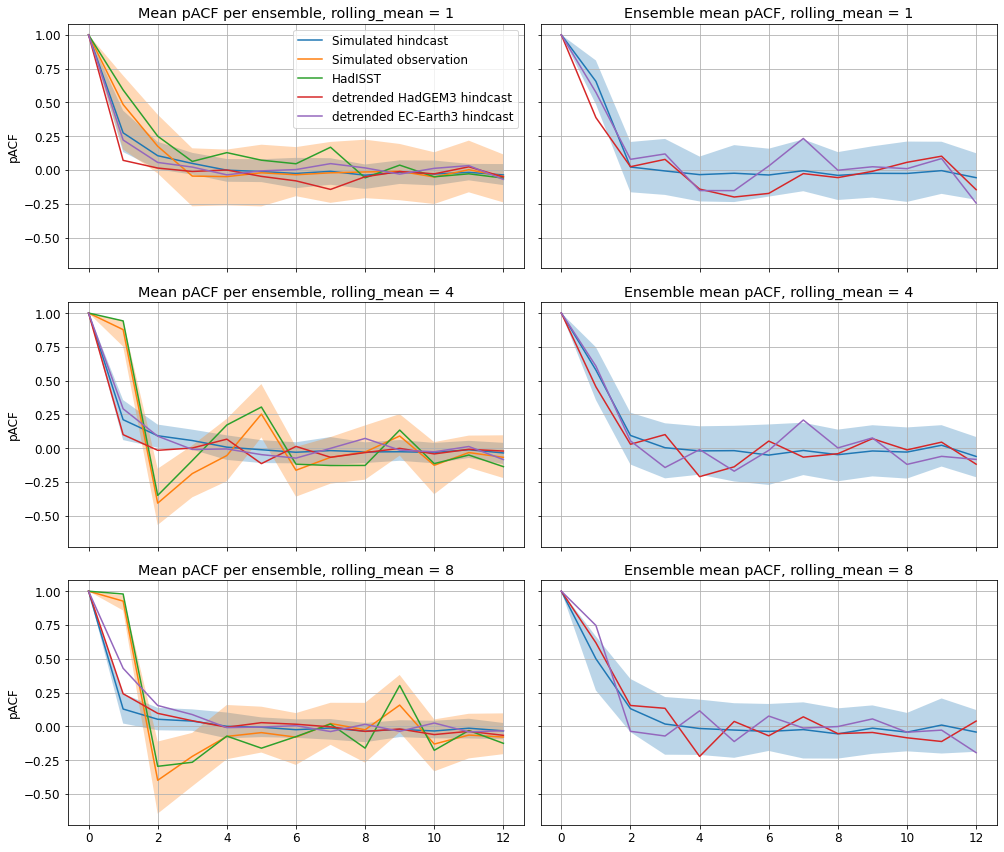

In [80]:
plot.acf(
    fcst.isel(
        member=range(AMV_HadGEM3.sizes["member"]), time=range(AMV_HadGEM3.sizes["time"])
    ),
    obsv.isel(time=range(AMV_HadGEM3.sizes["time"])),
    AMV,
    utils.detrend(AMV_HadGEM3),
    utils.detrend(AMV_ECEarth3),
    headings=[
        "Simulated hindcast",
        "Simulated observation",
        "HadISST",
        "detrended HadGEM3 hindcast",
        "detrended EC-Earth3 hindcast",
    ],
    partial=True,
    nlags=12,
)

## What is the effective sample size? Is there a blocksize that produces reasonable Type 1 error rates?

The effective sample size for a 45-year 8-year mean series estimated by:

$ N_{eff} = N \frac{1 - \rho_{f} \rho_{o}}{1 + \rho_{f} \rho_{o}} $

where  and  are the lag-1 autocorrelation coefficients for the forecasts and observations (Bretherton et al. [1991]) is:



In [83]:
N_time = 45
N_members = 40

fcst_long = ar_model.generate_samples_like(
    input_data,
    order="select_order",
    n_times=1000,
    n_samples=1000,
    n_members=N_members,
    rolling_means=[8],
    plot_diagnostics=False,
).sel(rolling_mean=8)

obsv_long = ar_model.generate_samples_like(
    input_data,
    order="select_order",
    n_times=1000,
    n_samples=1000,
    rolling_means=[8],
    plot_diagnostics=False,
).sel(rolling_mean=8)

Neff = stats.effective_sample_size(
    fcst.isel(time=slice(N_time), member=slice(N_member))
    .sel(rolling_mean=8)
    .mean("member"),
    obsv.isel(time=slice(N_time)).sel(rolling_mean=8),
)
Neff_long = stats.effective_sample_size(fcst_long.mean("member"), obsv_long, N_time)

print(
    f"Using N_time=45 to estimate autocorrelation: N_eff = {Neff.mean('sample').values:.1f} (std = {Neff.std('sample').values:.1f})"
)
print(
    f"Using N_time=1000 to estimate autocorrelation: N_eff = {Neff_long.mean('sample').values:.1f} (std = {Neff_long.std('sample').values:.1f})"
)

Using N_time=45 to estimate autocorrelation: N_eff = 9.0 (std = 3.9)
Using N_time=1000 to estimate autocorrelation: N_eff = 8.0 (std = 0.8)


The estimated blocksize, $L$, estimated by Wilks is (assuming the data follow a first-order regressive process):

$ L = (N - L + 1)^{\frac{2}{3} \left( 1 - \frac{N_{eff}}{N} \right)}  $

In [77]:
print(f"L = {stats.blocklength_Wilks(45, 8)}")

L = 7


Using a blocksize of 7 makes very little difference the above results